# The Challenge:

    The sinking of the Titanic is one of the most infamous shipwrecks in history.

    On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

    While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

    In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc). 

# Notes:

| Variable | Definition                                   | Key                                              |
|----------|----------------------------------------------|--------------------------------------------------|
| survival | Survival                                     | 0 = No, 1 = Yes                                  |
| pclass   | Ticket class                                 | 1 = 1st, 2 = 2nd, 3 = 3rd                        |
| sex      | Sex                                          |                                                  |
| Age      | Age in years                                 |                                                  |
| sibsp    | # of siblings / spouses aboard   the Titanic |                                                  |
| parch    | # of parents / children aboard   the Titanic |                                                  |
| ticket   | Ticket number                                |                                                  |
| fare     | Passenger fare                               |                                                  |
| cabin    | Cabin number                                 |                                                  |
| embarked | Port of Embarkation                          | C = Cherbourg, Q = Queenstown, S =   Southampton |

                                        pclass: A proxy for socio-economic status (SES)
                                        1st = Upper
                                        2nd = Middle
                                        3rd = Lower

                                        age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

                                        sibsp: The dataset defines family relations in this way...
                                        Sibling = brother, sister, stepbrother, stepsister
                                        Spouse = husband, wife (mistresses and fiancés were ignored)

                                        parch: The dataset defines family relations in this way...
                                        Parent = mother, father
                                        Child = daughter, son, stepdaughter, stepson
                                        Some children travelled only with a nanny, therefore parch=0 for them

# 1. Import Libraries:

In [149]:
#DF
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix

#Common Model Algorithms
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeRegressor

#Common Model Helpers
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_auc_score as auc
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')

# 1A. Sample Submission:

    Located below is a sample submission provided by Kaggle, you should align your results to something that looks like it but obviously with differen't answers. This gives users a good idea of how you think about answering the kaggle competition.

In [2]:
from IPython.display import display_html 

sample_submission = pd.read_csv('gender_submission.csv')

sample_head = sample_submission.head()
sample_tail = sample_submission.tail()
sample_sample = sample_submission.sample(5)

df1_styler = sample_head.style.set_table_attributes("style='display:inline'").set_caption('Head')
df2_styler = sample_tail.style.set_table_attributes("style='display:inline'").set_caption('Tail')
df3_styler = sample_sample.style.set_table_attributes("style='display:inline'").set_caption('Random Sample')

display_html(df1_styler._repr_html_()+df2_styler._repr_html_()+ df3_styler._repr_html_(), raw=True)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
,PassengerId,Survived
413,1305,0
414,1306,1
415,1307,0
416,1308,0


## 2. Meet and Greet Data

    This is the meet and greet step. Get to know your data by first name and learn a little bit about it. What does it look like (datatype and values), what makes it tick (independent/feature variables(s)), what's its goals in life (dependent/target variable(s)). Think of it like a first date, before you jump in and start poking it in the bedroom.

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
train.shape

(891, 12)

In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
train.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [7]:
train.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
428,429,0,3,"Flynn, Mr. James",male,NaN,0,0,364851,7.750,NaN,Q
766,767,0,1,"Brewe, Dr. Arthur Jackson",male,NaN,0,0,112379,39.600,NaN,C
264,265,0,3,"Henry, Miss. Delia",female,NaN,0,0,382649,7.750,NaN,Q
186,187,1,3,"O'Brien, Mrs. Thomas (Johanna ""Hannah"" Godfrey)",female,NaN,1,0,370365,15.500,NaN,Q
68,69,1,3,"Andersson, Miss. Erna Alexandra",female,17.0,4,2,3101281,7.925,NaN,S


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [9]:
train.isna().sum().sort_values(ascending = False)

Cabin          687
Age            177
Embarked         2
Fare             0
Ticket           0
Parch            0
SibSp            0
Sex              0
Name             0
Pclass           0
Survived         0
PassengerId      0
dtype: int64

In [10]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [11]:
survived = len(train[train['Survived'] ==1])
deaths = len(train[train['Survived'] ==0])

print(f"The number of people who survived is {survived}.")
print()
print(f"The number of people who died is {deaths}.")

The number of people who survived is 342.

The number of people who died is 549.


In [12]:
num_cols = train[train.select_dtypes(exclude=['object']).columns]
cat_cols = train[train.select_dtypes(include=['object']).columns]

print(f'The numerical cols are: {list(num_cols)} ({len(list(num_cols))}).\n')
print(f'The categorical cols are: {list(cat_cols)} ({len(list(cat_cols))}).\n')
print(f'Total number of cols: {len(list(train))}')

The numerical cols are: ['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'] (7).

The categorical cols are: ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'] (5).

Total number of cols: 12


# 3. EDA Analysis:

In [13]:
def tight():
    plt.tight_layout()
    plt.show()

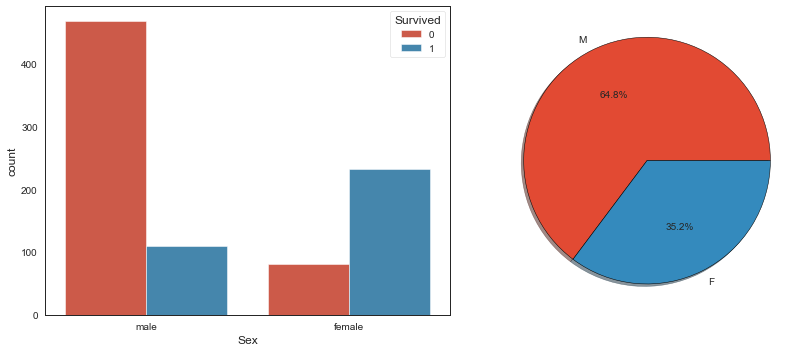

In [14]:
fig, (ax1,ax2) = plt.subplots(ncols = 2, nrows =1,figsize =(12,5))

sns.countplot(train['Sex'], hue = train['Survived'],ax =ax1)
ax2.pie(train['Sex'].value_counts()
        ,shadow = True,wedgeprops = {'edgecolor':'black'},autopct='%1.1f%%',labels =['M','F'])

tight()

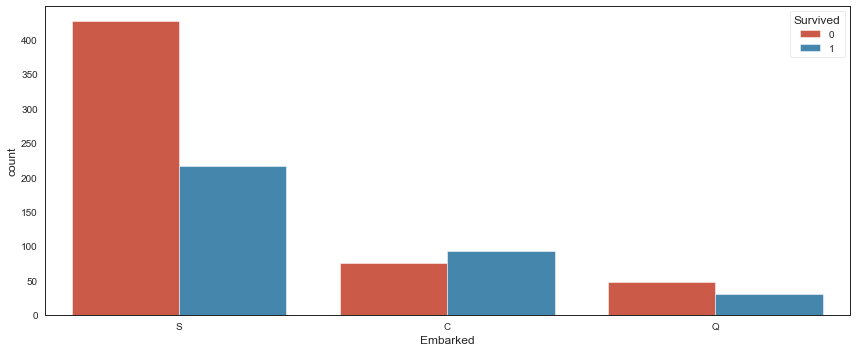

In [15]:
fig, ax = plt.subplots(figsize =(12,5))

sns.countplot(train['Embarked'], hue = train['Survived'])

tight()

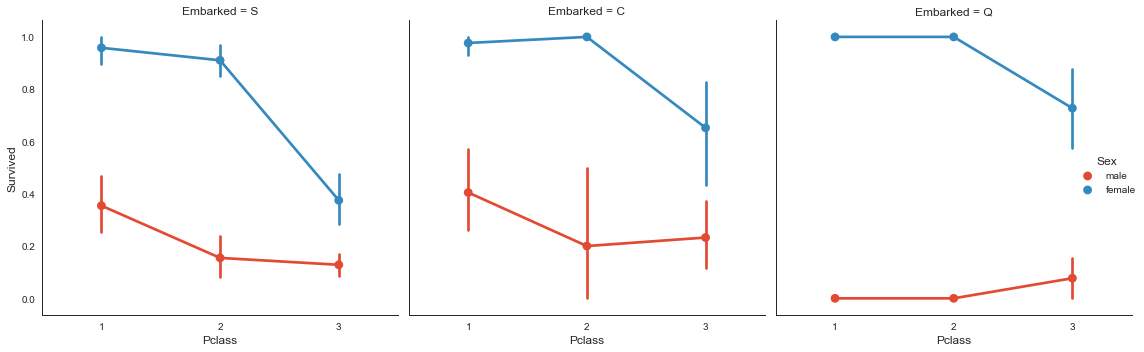

In [16]:
sns.catplot(data = train, kind = 'point', x = 'Pclass', y ='Survived', col ='Embarked', hue ='Sex')

tight()

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

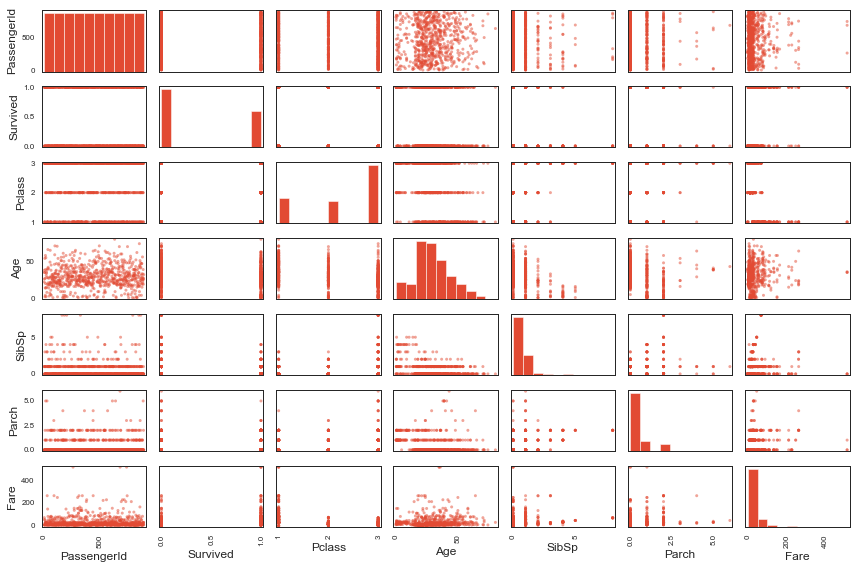

In [17]:
corr_matrix = num_cols.corr()

display(corr_matrix['Survived'].sort_values(ascending = False))
attributes = list(num_cols)

scatter_matrix(num_cols[attributes],figsize = (12,8))

tight()

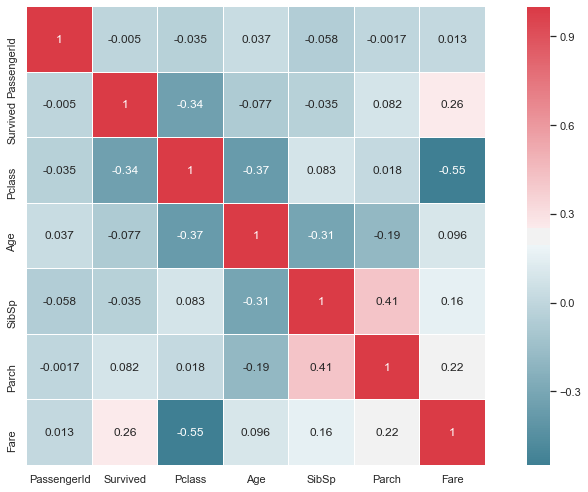

In [242]:
fig, ax = plt.subplots(figsize = (12,7))
colormap = sns.diverging_palette(220, 10, as_cmap = True)

sns.heatmap(corr_matrix,linewidth = 0.01,vmax=1.0,square = True, cmap = colormap,annot = True)

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

tight()

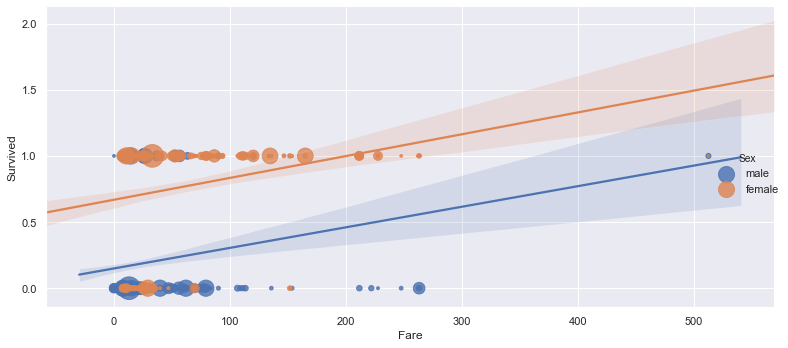

In [251]:
sns.lmplot(data = train, x ='Fare',y = 'Survived',hue = 'Sex',scatter_kws={"s": train['Fare']},height = 5,aspect =2)

tight()

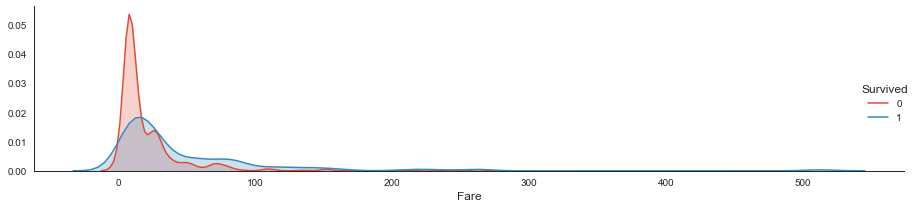

In [20]:
g = sns.FacetGrid( train, hue = 'Survived', aspect=4 )

g.map(sns.kdeplot, 'Fare', shade= True )
g.add_legend()

tight()

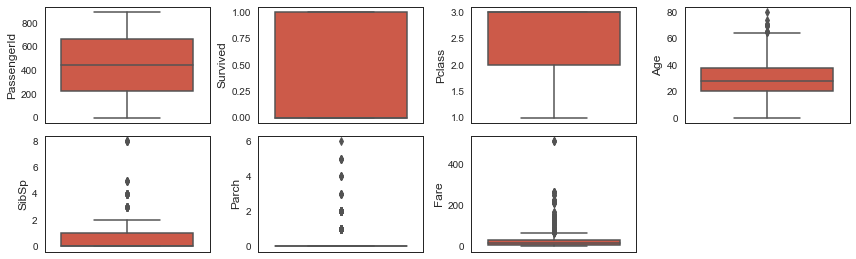

In [21]:
fig = plt.figure(figsize=(12, 18))

for i in range(len(num_cols.columns)):
    fig.add_subplot(10, 4, i+1)
    sns.boxplot(y=num_cols.iloc[:,i])

tight()

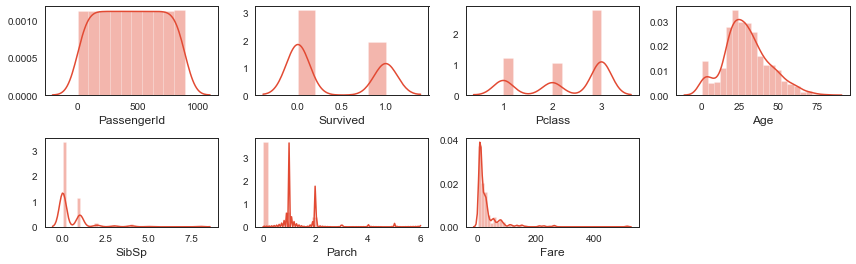

In [22]:
fig = plt.figure(figsize=(12,18))

for i in range(len(num_cols.columns)):
    fig.add_subplot(10,4,i+1)
    sns.distplot(num_cols.iloc[:,i].dropna())
    plt.xlabel(num_cols.columns[i])

tight()

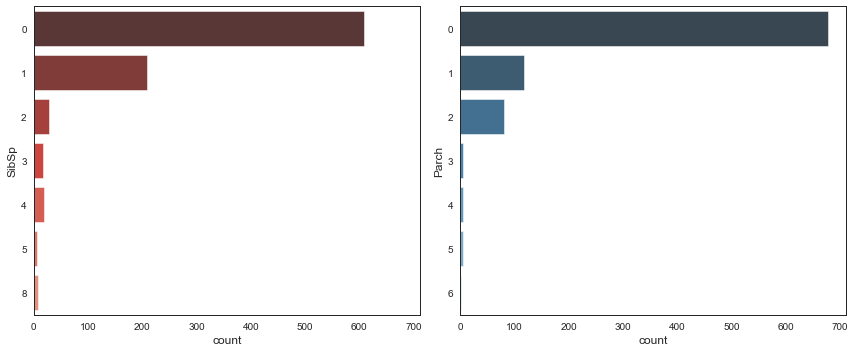

In [23]:
fig, (ax1,ax2) = plt.subplots(ncols = 2, nrows =1, figsize = (12,5), sharex = True)

sns.countplot(y= train['SibSp'],ax =ax1,palette = 'Reds_d')
sns.countplot(y =train['Parch'],ax =ax2, palette ='Blues_d')

tight()

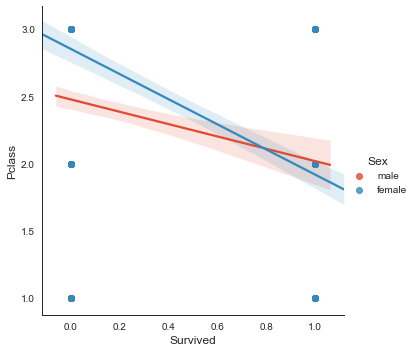

In [24]:
sns.lmplot(data = train, x = 'Survived', y ='Pclass', hue = 'Sex')

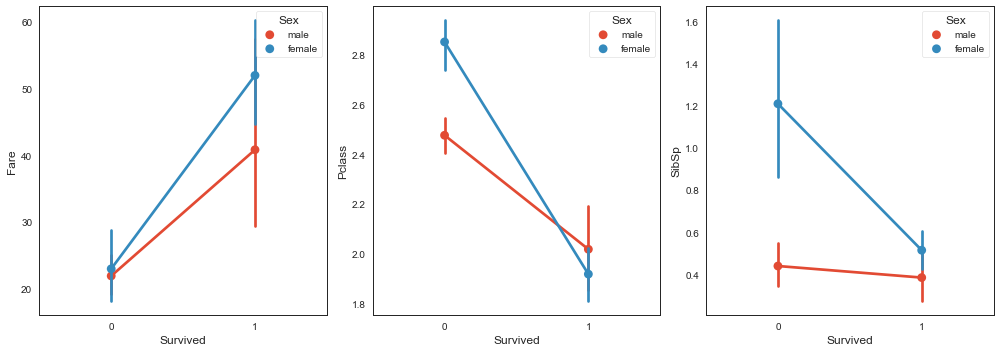

In [25]:
fig, (ax1,ax2,ax3) = plt.subplots(ncols = 3, nrows = 1, figsize = (14,5))

sns.pointplot(x = 'Survived', y= 'Fare', hue = 'Sex', data = train,ax =ax1)
sns.pointplot(x = 'Survived', y= 'Pclass', hue = 'Sex', data = train,ax= ax2)
sns.pointplot(x = 'Survived', y= 'SibSp', hue = 'Sex', data = train,ax= ax3)

tight()

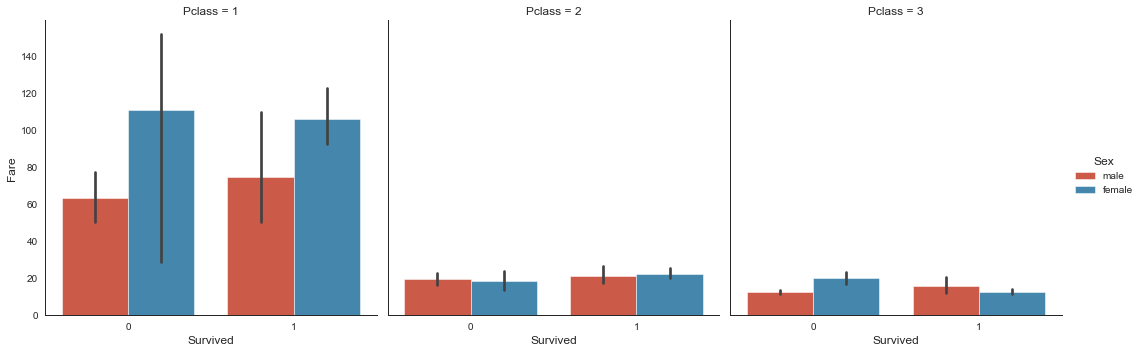

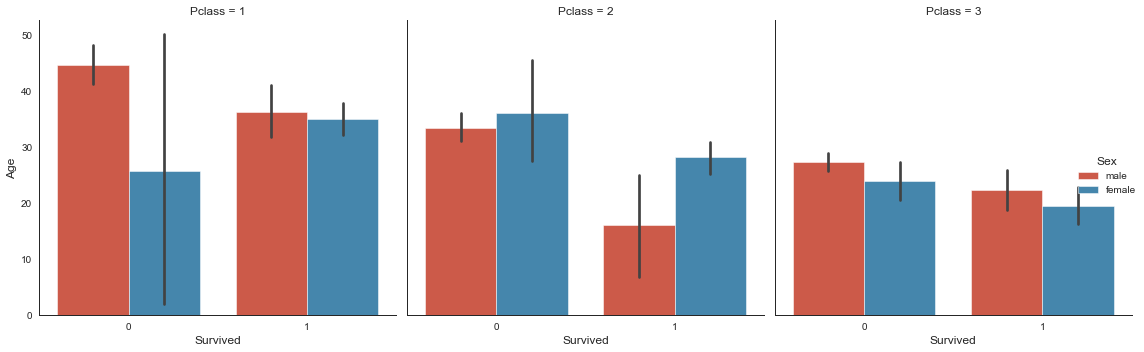

In [26]:
sns.catplot(data = train, kind = 'bar', col ='Pclass', x ='Survived', y = 'Fare', hue = 'Sex')
sns.catplot(data = train, kind = 'bar', col ='Pclass', x ='Survived', y = 'Age', hue = 'Sex')

tight()

# 4. Modelling:

In [27]:
X = train.copy()
y = train['Survived']

In [28]:
X = X.drop('Survived',axis=1)

In [29]:
X.isnull().sum().sort_values(ascending = False).head(1) #drop this useless as shit

Cabin    687
dtype: int64

In [30]:
display(corr_matrix['Survived'].sort_values(ascending = False))

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

In [31]:
X = X.drop('Cabin',axis =1)

In [32]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=42)

In [33]:
cat = list(X[X.select_dtypes(include=['object']).columns])
num = list(X[X.select_dtypes(exclude=['object']).columns])
my_cols = cat + num

In [34]:
X_train = X_train[my_cols].copy()
X_valid = X_valid[my_cols].copy()
X_test = test[my_cols].copy()

In [35]:
num_transformer = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
    ])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num),       
        ('cat',cat_transformer,cat),
        ])

In [36]:
print("Data Shape: {}".format(train.shape))
print("X_train Shape: {}".format(X_train.shape))
print("y_train Shape: {}".format(y_train.shape))

Data Shape: (891, 12)
X_train Shape: (712, 10)
y_train Shape: (712,)


In [37]:
X_train_prepared = preprocessor.fit_transform(X_train)
X_valid_prepared = preprocessor.transform(X_valid)

print(X_train_prepared.shape)
print(X_valid_prepared.shape)

(712, 1281)
(179, 1281)


In [38]:
def display_scores(scores):
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

# 4. Decesion Tree Classifier:

In [252]:
tree = DecisionTreeClassifier(max_depth =2)

tree.fit(X_train_prepared, y_train)
tree_predictions = tree.predict(X_train_prepared)

print("\nAccuracy Score for Decision Tree Classifier is: " + str(tree.score(X_train_prepared, y_train)))


Accuracy Score for Decision Tree Classifier is: 0.8033707865168539


### 4.1 Decision Tree Classifier - CV Scores:

In [40]:
tree_scores = cross_val_score(tree, X_train_prepared, y_train,scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)

display_scores(tree_rmse_scores)

Mean: 0.4653464228353399
Standard deviation: 0.08189429167116212


# 5. Random Forest Classifier:

In [253]:
forest = RandomForestClassifier(n_estimators = 10)

forest.fit(X_train_prepared, y_train)
forest_predictions = forest.predict(X_train_prepared)

print("\nAccuracy Score for Random Forest Classifier is: " + str(forest.score(X_train_prepared, y_train)))


Accuracy Score for Random Forest Classifier is: 0.9859550561797753


In [42]:
forest_predictions = forest.predict(X_train_prepared)

### 5.1 Random Forest Classifier - CV Scores

In [43]:
forest_scores = cross_val_score(forest, X_train_prepared, y_train,scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

display_scores(forest_rmse_scores)

Mean: 0.4366445492564842
Standard deviation: 0.06739988759680933


### 5.2 Random Forest Classifier - GridSearchCV

In [44]:
param_grid = {'bootstrap': [True, False],
 'max_depth': [1,2,3],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'n_estimators': [10, 100]}

forest_cv = GridSearchCV(forest, param_grid, n_jobs= 1, cv =10,scoring='roc_auc')
                  
forest_cv.fit(X_train_prepared, y_train)
print(forest_cv.best_params_)    
print(forest_cv.best_score_)

C:\Users\jeffr\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'bootstrap': True, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 100}
0.8492716709008844


In [45]:
forest_cv_predictions = forest_cv.predict(X_train_prepared)

# 6. SVC:

In [46]:
svc = SVC(gamma ='auto')

svc.fit(X_train_prepared, y_train)
svc_predictions = forest.predict(X_train_prepared)

svc_mse = mean_squared_error(y_train, svc_predictions)
svc_rmse = np.sqrt(svc_mse)

display(svc_rmse)

0.14022453903762566

### 6.1 SVC - CV Scores:

In [47]:
svc_scores = cross_val_score(svc, X_train_prepared, y_train,scoring="neg_mean_squared_error", cv=10)
svc_rmse_scores = np.sqrt(-svc_scores)

display_scores(svc_rmse_scores)

Mean: 0.5995947332556659
Standard deviation: 0.010957666301279497


# 7. Gradient Boosting Classifier:

In [48]:
gb = GradientBoostingClassifier(random_state = 10, learning_rate = 0.01)

gb.fit(X_train_prepared, y_train)
gb_predictions = gb.predict(X_train_prepared)

gb_mse = mean_squared_error(y_train, gb_predictions)
gb_rmse = np.sqrt(gb_mse)

display(gb_rmse)

0.40537124058895596

### 7.1 Gradient Boosting Classifier - CV Scores

In [49]:
gb_scores = cross_val_score(gb, X_train_prepared, y_train,scoring="neg_mean_squared_error", cv=10)
gb_rmse_scores = np.sqrt(-gb_scores)

display_scores(gb_rmse_scores)

Mean: 0.41274687487211914
Standard deviation: 0.08105510528951099


### 7.2 Gradient Boosting Classifier - GridSearchCV:

In [50]:
param_grid = { 
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth":[3,5,8],
    "n_estimators":[250,500]}

gb_cv = GridSearchCV(gb, param_grid, n_jobs= 1, cv =5,scoring ='roc_auc')
                
gb_cv.fit(X_train_prepared, y_train)
print(gb_cv.best_params_)    
print(gb_cv.best_score_)

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 250}
0.8597049882432823


# 8. Logistic Regression:

In [51]:
logreg = LogisticRegression(solver = 'liblinear')

logreg.fit(X_train_prepared, y_train)
logreg_predictions = logreg.predict(X_train_prepared)

logreg_mse = mean_squared_error(y_train, logreg_predictions)
logreg_rmse = np.sqrt(logreg_mse)

display(logreg_rmse)

0.29509092104873924

### 8.1 Logistic Regression CV Scores:

In [52]:
logreg_scores = cross_val_score(logreg, X_train_prepared, y_train,scoring="neg_mean_squared_error", cv=10)
logreg_rmse_scores = np.sqrt(-logreg_scores)

display_scores(logreg_rmse_scores)

Mean: 0.41821159320433693
Standard deviation: 0.10217357239690046


### 8.2 Logistic Regression GridSearchCV:

In [53]:
param_grid = { 
    "C": [0.5,1.0,10.0,25.0,50.0],
    "solver":['liblinear','lbfgs','sag'],
    "max_iter":[1000,2500,5000],
}

logreg_cv = GridSearchCV(logreg, param_grid, n_jobs= 1, cv =5,scoring = 'roc_auc')
                
logreg_cv.fit(X_train_prepared, y_train)
print(logreg_cv.best_params_)    
print(logreg_cv.best_score_)

{'C': 50.0, 'max_iter': 1000, 'solver': 'lbfgs'}
0.8618863838914939


# 9. KNN:

In [54]:
knn = KNeighborsClassifier(n_neighbors = 5)

knn.fit(X_train_prepared, y_train)
knn_predictions = knn.predict(X_train_prepared)

knn_mse = mean_squared_error(y_train, knn_predictions)
knn_rmse = np.sqrt(knn_mse)

display(knn_rmse)

0.37663501242485364

### 9.1 KNN CV Scores:

In [55]:
knn_scores = cross_val_score(knn, X_train_prepared, y_train,scoring="neg_mean_squared_error", cv=10)
knn_rmse_scores = np.sqrt(-knn_scores)

display_scores(knn_rmse_scores)

Mean: 0.45372378187988804
Standard deviation: 0.07861156290767025


### 9.2. KNN GridSearchCV:

In [56]:
param_grid = { 
    "n_neighbors": [1,5,10,25],
    "weights":['uniform','distance'],
    "leaf_size":[30,50,100],
    'algorithm':['auto','brute'],
}

knn_cv = GridSearchCV(knn, param_grid, n_jobs= 1, cv =10,iid = False,scoring ='roc_auc')
                
knn_cv.fit(X_train_prepared, y_train)
print(knn_cv.best_params_)    
print(knn_cv.best_score_)

{'algorithm': 'auto', 'leaf_size': 30, 'n_neighbors': 25, 'weights': 'distance'}
0.8328780684336239


# 10. Linear SVM:

In [57]:
linear_svm = LinearSVC()

linear_svm.fit(X_train_prepared, y_train)
linear_svm_predictions = linear_svm.predict(X_train_prepared)

linear_svm_mse = mean_squared_error(y_train, knn_predictions)
linear_svm_rmse = np.sqrt(linear_svm_mse)

display(linear_svm_rmse)

0.37663501242485364

### 10.1 Linear SVM CV Scores:

In [58]:
linear_svm_scores = cross_val_score(linear_svm, X_train_prepared, y_train,scoring="neg_mean_squared_error", cv=10)
linear_svm_rmse_scores = np.sqrt(-linear_svm_scores)

display_scores(linear_svm_rmse_scores)

Mean: 0.42900309227212086
Standard deviation: 0.08277848732229993


### 10.2 Linear SVM GridSearchCV:

In [68]:
param_grid = { 
    "C": [1.0,5.0,10.0,25.0],
    "max_iter":[1000,2500,5000,10000,15000],
    "fit_intercept":[True,False],
}

linear_svm_cv = GridSearchCV(linear_svm, param_grid, n_jobs= 1, cv =10,iid = False,scoring = 'roc_auc')
                
linear_svm_cv.fit(X_train_prepared, y_train)
print(linear_svm_cv.best_params_)    
print(linear_svm_cv.best_score_)

C:\Users\jeffr\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\jeffr\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


{'C': 25.0, 'fit_intercept': True, 'max_iter': 1000}
0.8621736596736597


# 11. XGBoost:

In [60]:
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)

xgb.fit(X_train_prepared, y_train)
xgb_predictions = xgb.predict(X_train_prepared)

xgb_mse = mean_squared_error(y_train, knn_predictions)
xgb_rmse = np.sqrt(linear_svm_mse)

display(xgb_rmse)

0.37663501242485364

### 11.1 XGBoost CV Scores:

In [61]:
xgb_scores = cross_val_score(xgb, X_train_prepared, y_train,scoring="neg_mean_squared_error", cv=10)
xgb_rmse_scores = np.sqrt(-xgb_scores)

display_scores(xgb_rmse_scores)

Mean: 0.40053675213554535
Standard deviation: 0.08172218164592678


### 11.2 XGBoost GridSearchCV:

In [62]:
param_grid = {
        'n_estimators': [10,100,500],
        'gamma': [0.5, 1,5],
        'learning_rate':[0.01,0.02,0.05,0.10]
}

xgb_cv = GridSearchCV(xgb, param_grid, n_jobs= 1, cv =10,iid = False,scoring ='roc_auc')
                
xgb_cv.fit(X_train_prepared, y_train)
print(xgb_cv.best_params_)    
print(xgb_cv.best_score_)

{'gamma': 1, 'learning_rate': 0.01, 'n_estimators': 100}
0.8612117255172811


# 12. Evaluation:

### 12.1 Confusion Matrix:

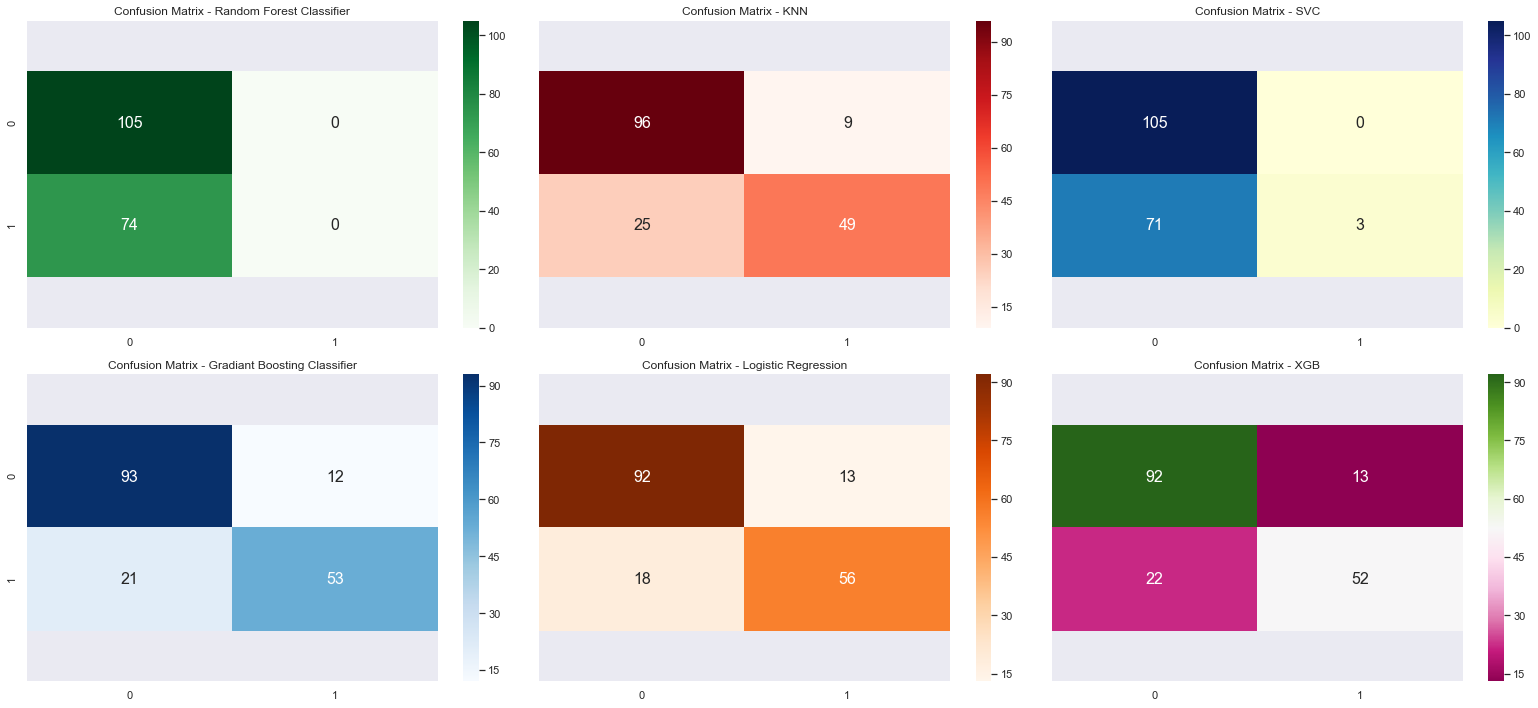

In [240]:
forest_predictions = forest_cv.predict(X_valid_prepared)
knn_predictions = knn_cv.predict(X_valid_prepared)
gb_predictions = gb_cv.predict(X_valid_prepared)
logreg_predictions = logreg_cv.predict(X_valid_prepared)
xgb_predictions = xgb_cv.predict(X_valid_prepared)
svc_predictions = svc.predict(X_valid_prepared)

fig, ax = plt.subplots(2,3,figsize = (22,10),sharey = True)

sns.heatmap(confusion_matrix(y_valid,forest_predictions),annot = True, fmt ='d',ax=ax[0,0],cmap = 'Greens',annot_kws={"size": 16},)
sns.heatmap(confusion_matrix(y_valid,knn_predictions),annot = True, fmt = 'd', ax=ax[0,1], cmap = 'Reds',annot_kws={"size": 16},)
sns.heatmap(confusion_matrix(y_valid,gb_predictions),annot = True, fmt = 'd', ax=ax[1,0], cmap = 'Blues',annot_kws={"size": 16},)
sns.heatmap(confusion_matrix(y_valid,logreg_predictions),annot = True, fmt = 'd', ax=ax[1,1], cmap = 'Oranges',annot_kws={"size": 16},)
sns.heatmap(confusion_matrix(y_valid,xgb_predictions),annot = True, fmt = 'd', ax=ax[1,2], cmap = 'PiYG',annot_kws={"size": 16},)
sns.heatmap(confusion_matrix(y_valid,svc_predictions),annot = True, fmt = 'd', ax=ax[0,2], cmap = 'YlGnBu',annot_kws={"size": 16},)

ax[0,0].set_title('Confusion Matrix - Random Forest Classifier')
ax[0,1].set_title('Confusion Matrix - KNN')
ax[1,0].set_title('Confusion Matrix - Gradiant Boosting Classifier')
ax[1,1].set_title('Confusion Matrix - Logistic Regression')
ax[1,2].set_title('Confusion Matrix - XGB')
ax[0,2].set_title('Confusion Matrix - SVC')

bottom, top = ax1.get_ylim()
ax[0,0].set_ylim(bottom + 0.5, top - 0.5)
ax[0,1].set_ylim(bottom + 0.5, top - 0.5)
ax[1,0].set_ylim(bottom + 0.5, top - 0.5)
ax[1,1].set_ylim(bottom + 0.5, top - 0.5)
ax[1,2].set_ylim(bottom + 0.5, top - 0.5)
ax[0,2].set_ylim(bottom + 0.5, top - 0.5)

tight()

### 12.2 AUC Scores:

In [121]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_valid, forest_cv.predict_proba(X_valid_prepared)[:, 1])
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_valid, knn_cv.predict_proba(X_valid_prepared)[:, 1])
fpr_gbrt, tpr_gbrt, thresholds_gbrt = roc_curve(y_valid, gb_cv.predict_proba(X_valid_prepared)[:, 1])
fpr_logreg, tpr_logreg, thresholds_logreg = roc_curve(y_valid, logreg_cv.predict_proba(X_valid_prepared)[:, 1])
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_valid, xgb_cv.predict_proba(X_valid_prepared)[:, 1])
fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_valid, svc.decision_function(X_valid_prepared))
fpr_linearsvm, tpr_linearsvm, thresholds_linearsvm = roc_curve(y_valid, linear_svm_cv.decision_function(X_valid_prepared))

roc_auc_forest = auc(y_valid,forest_cv.predict_proba(X_valid_prepared)[:, 1])
roc_auc_knn = auc(y_valid,knn_cv.predict_proba(X_valid_prepared)[:, 1])
roc_auc_gb = auc(y_valid,gb_cv.predict_proba(X_valid_prepared)[:, 1])
roc_auc_logreg = auc(y_valid,logreg_cv.predict_proba(X_valid_prepared)[:, 1])
roc_auc_xgb = auc(y_valid,xgb_cv.predict_proba(X_valid_prepared)[:, 1])
roc_auc_svc = auc(y_valid,svc.decision_function(X_valid_prepared))
roc_auc_linearsvm = auc(y_valid,linear_svm_cv.decision_function(X_valid_prepared))

### 12.3 ROC Curve:

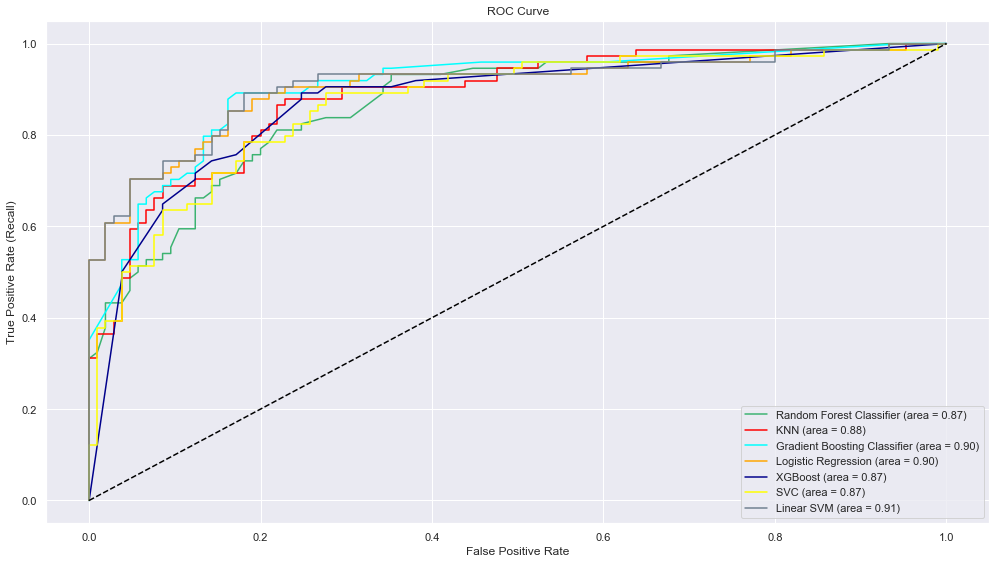

In [243]:
sns.set(style="darkgrid")

fig, ax = plt.subplots(figsize = (14,8))

plt.plot(fpr_rf,tpr_rf,color='mediumseagreen',label = 'Random Forest Classifier (area = %0.2f)' % roc_auc_forest)
plt.plot(fpr_knn,tpr_knn,color='red',label = 'KNN (area = %0.2f)' % roc_auc_knn)
plt.plot(fpr_gbrt,tpr_gbrt,color='cyan',label = 'Gradient Boosting Classifier (area = %0.2f)' % roc_auc_gb)
plt.plot(fpr_logreg,tpr_logreg,color='Orange',label = 'Logistic Regression (area = %0.2f)' % roc_auc_logreg)
plt.plot(fpr_xgb,tpr_xgb,color='DarkBlue',label = 'XGBoost (area = %0.2f)' % roc_auc_xgb)
plt.plot(fpr_svc,tpr_svc,color='yellow',label = 'SVC (area = %0.2f)' % roc_auc_svc)
plt.plot(fpr_linearsvm,tpr_linearsvm,color='slategrey',label = 'Linear SVM (area = %0.2f)' % roc_auc_linearsvm)
plt.plot([0, 1], [0, 1],linestyle='--',color ='black')

plt.legend()
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')

tight()

# 13. Final Model:

In [250]:
final_model = gb_cv.best_estimator_

In [248]:
final_predictions = final_model.predict(X_test_prepared)

In [249]:
output = pd.DataFrame({'PassengerId': X_test.PassengerId,
                       'Survived': final_predictions})

output.to_csv('submission.csv', index=False)